In [68]:
# Importaciones necesarias

try:
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
except ImportError:
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
    
try:
    from skimage.feature import hog
    from skimage.color import rgb2gray
except ImportError:
    !pip3 install scikit-image
    from skimage.feature import hog
    from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms


torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

In [69]:
try:
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
except ImportError:
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

try:
    from skimage.feature import hog
    from skimage.color import rgb2gray
except ImportError:
    !pip3 install scikit-image

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

## Arquitectura dun MLP modular

In [70]:
class MLP(nn.Module):
    def __init__(self, input_neurons, output_neurons, hidden_layers):
        super(MLP, self).__init__()
        self.input_neurons=input_neurons
        self.output_neurons=output_neurons
        self.hidden_layers=hidden_layers

        self.flatten = nn.Flatten()

        layers=[]
        prev_neurons=input_neurons
        if isinstance(hidden_layers,list):
            for i in hidden_layers:
                layers.append(nn.Linear(prev_neurons,i))
                layers.append(nn.ReLU())
                prev_neurons=i
        else:
            print("ERROR DE FORMATO, PASALE UNA LIST COMO HIDDENLAYERS")
        
        layers.append(nn.Linear(prev_neurons,output_neurons))

        self.hiddenlayer_stack = nn.Sequential(*layers)


    def forward(self, x):

        x=self.flatten(x)
        salida=self.hiddenlayer_stack(x)
        return salida

In [71]:
# Ejemplo de uso 

mlp = MLP(
    input_neurons=128*128*3,
    output_neurons=10,
    hidden_layers=[64,32]
)

def get_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"O modelo ten {get_parameters(mlp):,} parámetros")

O modelo ten 3,148,202 parámetros


## Arquitectura CNN modular

In [ ]:
# Definición de la clase CNN
class CNN(nn.Module):

    # input_channels: número de canales de entrada 
    # conv_lavers: número de capas convolucionales
    # first_conv_filters: num filtros primera capa, se duplicarán en cada capa
    # con_kernel_size: tam filtros convolucionales (cuadrados)
    # batch_norm: booleano para usar normalización por lotes
    # hidden_mlp_layers: número de neuronas en la capa oculta de la red MLP
    # output_neurons: número de neuronas de salida
    # input_size: tamaño de las imagenes que le vamos a pasar
    def __init__(self, input_channels, conv_lavers, first_conv_filters, conv_kernel_size, batch_norm, hidden_mlp_layers, output_neurons,input_size):
        
        # Construtor 
        super(CNN, self).__init__()  

        size_flatten=input_size*input_channels
        pad_substract=conv_kernel_size-1

        # Arrays auxiliares
        layers = [] # Contiene las capas

        # Definición de capas según los parámetros
        for _ in range(conv_lavers): # Bucle para el número de capas convolucionades pasadas por parámetro
            layers.append(nn.Conv2d(in_channels=input_channels, out_channels=first_conv_filters, kernel_size=conv_kernel_size))
            if batch_norm: # Si se usa normalización por lotes, se añade la capa de normalización
                layers.append(nn.BatchNorm2d(first_conv_filters)) # Capa de normalización por lotes
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # Capa de max pooling
            layers.append(nn.ReLU()) # Capa de activación ReLU
            input_channels = first_conv_filters # Actualiza el número de canales de entrada para la siguiente capa convolucional
            first_conv_filters *= 2 # Duplica el número de filtros para la siguiente capa convolucional
        
        # Capa de convolución final
        self.conv = nn.Sequential(*layers) # Capa convolucional compuesta por las capas definidas en el bucle anterior
        
        # Capa de aplanamento
        self.flatten = nn.Flatten()



        # MLP
        layers_mlp = []
        prev_neurons=57600
        #prev_neurons = first_conv_filters
        if isinstance(hidden_mlp_layers,list):
            for i in hidden_mlp_layers:
                layers_mlp.append(nn.Linear(prev_neurons,i))
                layers_mlp.append(nn.ReLU())
                prev_neurons=i
        else:
            print("ERROR DE FORMATO, PASALE UNA LIST COMO HIDDENLAYERS")

        layers_mlp.append(nn.Linear(prev_neurons,output_neurons))
        
        self.mlp = nn.Sequential(*layers_mlp)

    def forward(self, x):

        x = self.conv(x)
        print("TORRIJAS",x.shape)
        x = self.flatten(x)
        self.tamanho=x.shape[1]
        x = self.mlp(x)

        return x   

In [109]:
# Ejemplo de uso 

cnn = CNN(
    input_channels=3,
    conv_lavers=2,
    first_conv_filters=32,
    conv_kernel_size=3,
    batch_norm=True,
    hidden_mlp_layers=[128],
    output_neurons=10,
    input_size=[128,128]
)

def get_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"O modelo ten {get_parameters(cnn):,} parámetros")

O modelo ten 7,393,802 parámetros


In [110]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)

epochs = 20

## Adestramento e optimización dos modelos

In [116]:
def train(dataloader, model, loss_fn, optimizer):
    # Obtemos o número total de lotes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de adestramento
    model.train()
    # Iteramos sobre os lotes
    n_batch = 0
    for batch_imgs, batch_labels in dataloader:
        # Obtemos as predicións para o lote actual
        batch_predicted_probabilities = model(batch_imgs)
        # Calculamos a perda
        loss = loss_fn(batch_predicted_probabilities, batch_labels)
        # Poñemos a cero os gradientes dos parámetros do modelo
        optimizer.zero_grad()
        # Realizamos a retropropagación para calcular os gradientes de cada parámetro
        loss.backward()
        # Actualizamos os parámetros do modelo utilizando os gradientes calculados
        optimizer.step()

        # Cada 100 lotes, imprimimos a perda e o progreso
        if n_batch % 100 == 0:
            loss, imgs_processed = loss.item(), n_batch * len(batch_imgs)
            print(f"perda: {loss:>7f}  [{imgs_processed:>5d}/{num_images:>5d}]")

        n_batch += 1

    return loss

def test(dataloader, model):
    # Obtemos o número total de imaxes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de avaliación (sen calcular gradientes)
    model.eval()
    # Inicializamos as variables para gardar a perda e a precisión
    test_loss, correct = 0, 0
    # Inicializamos as listas para gardar as clases predicidas e as clases reais
    test_predicted_classes, test_true_classes = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            # Obtemos as predicións para o lote actual
            batch_predicted_probabilities = model(batch_imgs)
            # Calculamos a perda e acumulamos o valor
            test_loss += loss_fn(batch_predicted_probabilities, batch_labels).item()
            # Calculamos as clases predicidas (aquelas con maior probabilidade)
            batch_predicted_classes = batch_predicted_probabilities.argmax(dim=1)
            # Obtemos o número de predicións correctas e acumulamos o valor
            correct += (batch_predicted_classes == batch_labels).sum().item()
            # Gardamos as clases predicidas e as clases reais. Precisamos convertelas a listas de Python coa función tolist()
            test_predicted_classes.extend(batch_predicted_classes.tolist())
            test_true_classes.extend(batch_labels.tolist())
    # Calculamos a perda media e o porcentaxe de predicións correctas (accuracy), dividindo entre o número total de imaxes
    test_loss /= num_images
    correct /= num_images
    print(f"Perda media: {test_loss:>8f} Accuracy: {correct*100:>0.1f}%\n")

    return test_predicted_classes, test_true_classes

def val(dataloader, model):
    # Obtemos o número total de imaxes
    num_images = len(dataloader)
    # Poñemos o modelo en modo de avaliación (sen calcular gradientes)
    model.eval()
    # Inicializamos as variables para gardar a perda e a precisión
    test_loss, correct = 0, 0
    # Inicializamos as listas para gardar as clases predicidas e as clases reais
    test_predicted_classes, test_true_classes = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            # Obtemos as predicións para o lote actual
            batch_predicted_probabilities = model(batch_imgs)
            # Calculamos a perda e acumulamos o valor
            test_loss += loss_fn(batch_predicted_probabilities, batch_labels).item()
            # Calculamos as clases predicidas (aquelas con maior probabilidade)
            batch_predicted_classes = batch_predicted_probabilities.argmax(dim=1)
            # Obtemos o número de predicións correctas e acumulamos o valor
            correct += (batch_predicted_classes == batch_labels).sum().item()
            # Gardamos as clases predicidas e as clases reais. Precisamos convertelas a listas de Python coa función tolist()
            test_predicted_classes.extend(batch_predicted_classes.tolist())
            test_true_classes.extend(batch_labels.tolist())
    # Calculamos a perda media e o porcentaxe de predicións correctas (accuracy), dividindo entre o número total de imaxes
    test_loss /= num_images
    correct /= num_images

    return test_loss


In [117]:
def plot_confusion_matrix(y_true, y_pred, labels_map):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, labels_map.values(), rotation=45)
    plt.yticks(tick_marks, labels_map.values())

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f"{conf_matrix[i, j]}",
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Clase real')
    plt.xlabel('Clase predicida')
    plt.show()

In [118]:
torchvision.datasets.Imagenette("dataset", download=True, size="160px")

Dataset Imagenette
    Number of datapoints: 9469
    Root location: dataset

In [119]:


# Transformaciones básicas
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.228,0.224,0.225])
])#con  160 160 41%

dataset = ImageFolder(root="dataset/imagenette2-160/train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
tr_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 16
tr_dataloader = DataLoader(dataset=tr_data,
                              batch_size=batch_size,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                              batch_size=batch_size,
                              shuffle=True)

dataset_test = ImageFolder(root="dataset/imagenette2-160/val", transform=transform)
test_dataloader = DataLoader(dataset=dataset_test,
                              batch_size=batch_size,
                              shuffle=True)


In [120]:
def train_test(model):
    loss_fn = nn.CrossEntropyLoss()

    learning_rate = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Cambiar mlp por el modelo que se use

    epochs = 50
    patience = 10 

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(tr_dataloader, model, loss_fn, optimizer)
        val_loss = val(val_dataloader, model)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print("Nonimprovement = ",epochs_without_improvement)

        if epochs_without_improvement >= patience:
            print("Early Stopping")
            break

    model.load_state_dict(torch.load("best_model.pth")) 
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Perda de adestramento')
    plt.plot(val_losses, label='Perda de validación')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

    test_predicted_classes, test_true_classes = test(test_dataloader, model)
    return test_predicted_classes,test_true_classes


In [121]:
predicted_cnn,true_cnn=train_test(cnn)

Epoch 1
-------------------------------
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
perda: 2.477730  [    0/ 7575]
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 57600])
TORRIJAS torch.Size([16, 64, 30, 30])
TORRIJAS2 torch.Size([16, 5

KeyboardInterrupt: 

Epoch 1
-------------------------------
perda: 0.934496  [    0/ 7575]
perda: 1.124505  [ 1600/ 7575]
perda: 1.362837  [ 3200/ 7575]
perda: 1.502201  [ 4800/ 7575]
perda: 0.966680  [ 6400/ 7575]
Epoch 2
-------------------------------
perda: 1.217494  [    0/ 7575]
perda: 1.130121  [ 1600/ 7575]
perda: 1.345833  [ 3200/ 7575]
perda: 1.042754  [ 4800/ 7575]
perda: 1.119810  [ 6400/ 7575]
Nonimprovement =  1
Epoch 3
-------------------------------
perda: 0.828297  [    0/ 7575]
perda: 1.494821  [ 1600/ 7575]
perda: 1.039193  [ 3200/ 7575]
perda: 1.286519  [ 4800/ 7575]
perda: 0.981032  [ 6400/ 7575]
Nonimprovement =  2
Epoch 4
-------------------------------
perda: 1.265560  [    0/ 7575]
perda: 1.316446  [ 1600/ 7575]
perda: 1.490297  [ 3200/ 7575]
perda: 1.654441  [ 4800/ 7575]
perda: 1.002402  [ 6400/ 7575]
Nonimprovement =  3
Epoch 5
-------------------------------
perda: 1.436566  [    0/ 7575]
perda: 1.268935  [ 1600/ 7575]
perda: 0.840632  [ 3200/ 7575]
perda: 0.832597  [ 4800/ 75

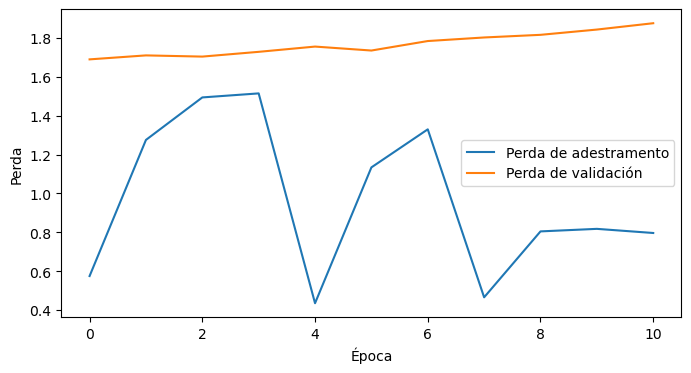

Perda media: 0.105284 Accuracy: 43.9%



In [85]:
predicted,true=train_test(mlp)

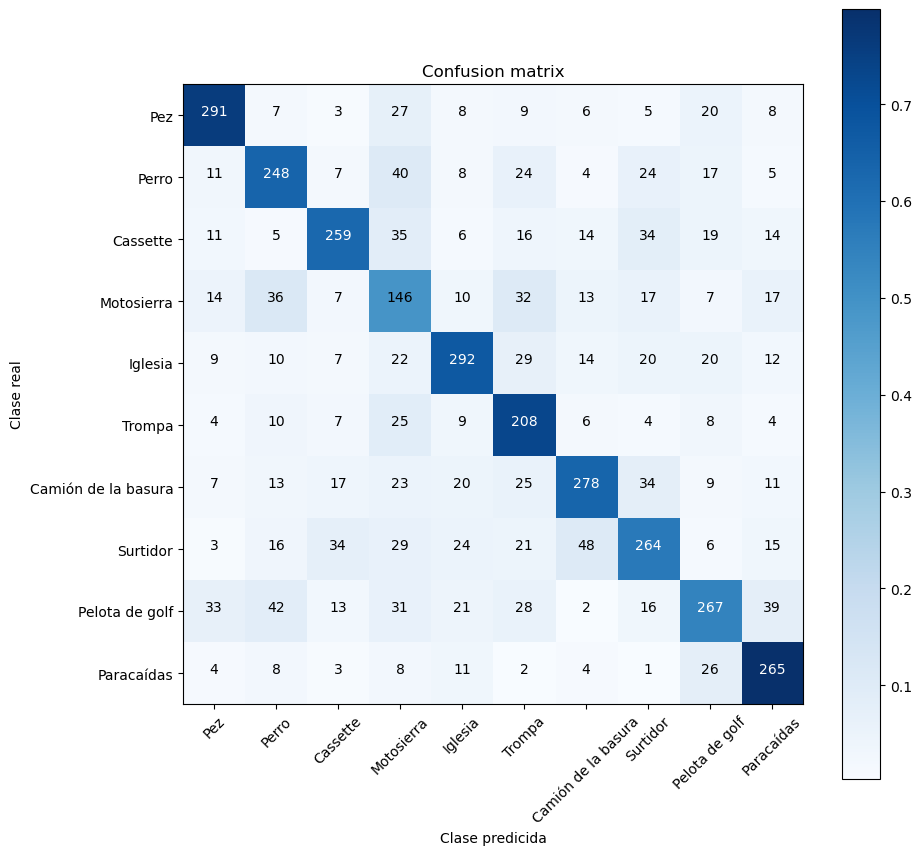

In [107]:
labels_map = {
    0: "Pez",
    1: "Perro",
    2: "Cassette",
    3: "Motosierra",
    4: "Iglesia",
    5: "Trompa",
    6: "Camión de la basura",
    7: "Surtidor",
    8: "Pelota de golf",
    9: "Paracaídas",
}
plot_confusion_matrix(predicted_cnn,true_cnn, labels_map)
#plot_confusion_matrix(test_true_classes, test_predicted_classes, labels_map)